# Discrete hedging experiment for a European Call option under the Heston model using the Wilmott $\Delta$

> TODO: Add a description to the experiment

> Under the Heston but we are using the Black-Scholes delta for hedging

In [1]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [2]:
import numpy as np
import pandas as pd

from jax import vmap, grad
import jax.numpy as jnp
import matplotlib.pyplot as plt
import scienceplots
plt.style.use(['science','no-latex'])

from jaxfin.models.heston import UnivHestonModel
from jaxfin.price_engine.black_scholes import gamma_european
from jaxfin.price_engine.fft import fourier_inv_call, delta_call_fourier

from src.experimental.bs_iv import IV_brent
import py_vollib_vectorized

In [3]:
seed = 42

$$
S(0) = 100 \\
\sigma = 0.2 \\
\mu = 0.00 \\
$$

Let set $N = 252$, which means that we are rebalancing our portfolio daily.

In [4]:
# Initialize the Univariate Heston Model
s0 = 100.0
v0 = 0.04
mean = 0.0
kappa = 1.0
theta = 0.04
sigma = 0.1
rho = -0.7

heston_model = UnivHestonModel(s0, v0, mean, kappa, theta, sigma, rho)

In [5]:
maturity = 1.0
N = 252
dt = maturity / N
n_sim = 100
risk_adv = 2

stock_paths, var_process = heston_model.sample_paths(maturity, N, n_sim)

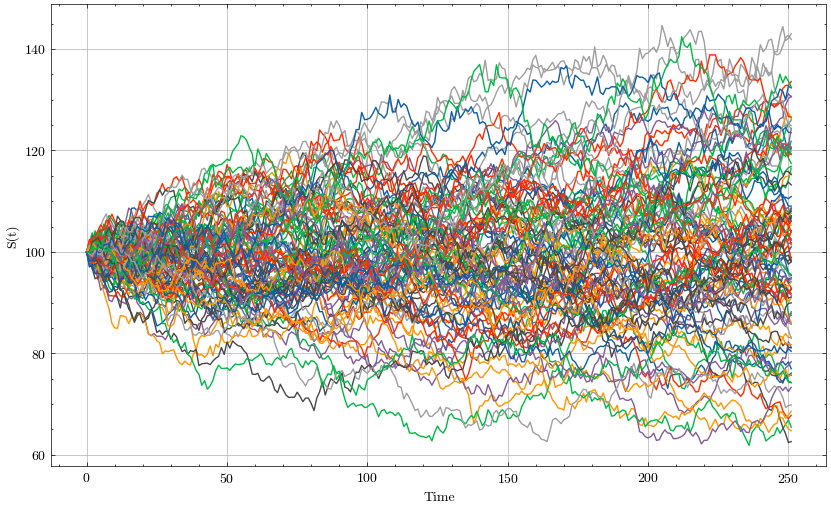

In [6]:
plt.figure(figsize=(10, 6))
plt.plot(stock_paths[:, :100])
plt.ylabel('S(t)')
plt.xlabel('Time')
plt.grid()
plt.show()

In [7]:
discount_rate = 0.0
r = discount_rate
dividends = 0.0

## Hedging experiment without transaction costs

In [8]:
ticksize = 0.00
K = 100
maturity = 1.0
N = 252
n_sim = 100

v_gamma_european = vmap(gamma_european, in_axes=(0, None, None, None, None))
v_v_gamma_european = vmap(v_gamma_european, in_axes=(None, None, None, 0, None))
v_fourier_delta_call = vmap(delta_call_fourier, in_axes=(0, None, None, None, None, None, None, None, None))
v_v_fourier_delta_call = vmap(v_fourier_delta_call, in_axes=(None, None, None, 0, None, None, None, None, None))
v_fourier_inv_call = vmap(fourier_inv_call, in_axes=(0, None, None, None, None, None, None, None, None))
v_v_fourier_inv_call = vmap(v_fourier_inv_call, in_axes=(None, None, None, 0, None, None, None, None, None))

In [9]:
def heston_vega(s0, K, T, v, mu, theta, sigma, kappa, rho):
    return grad(fourier_inv_call, argnums=3)(s0, K, T, v, mu, theta, sigma, kappa, rho)

_v_heston_vega = vmap(heston_vega, in_axes=(0, None, None, None, None, None, None, None, None))
v_heston_vega = vmap(_v_heston_vega, in_axes=(None, None, None, 0, None, None, None, None, None))

In [10]:
def get_heston_deltas(stock_paths, var_process, K, T, mu, theta, sigma, kappa, rho, N):
    dt = maturity / N
    deltas = [v_v_fourier_delta_call(stock_paths[0], K, T, var_process[0], mu, theta, sigma, kappa, rho).diagonal()]
    deltas_ = [v_v_fourier_delta_call(
        stock_paths[i], 
        K, 
        T - i * dt, 
        var_process[i - 1], 
        mu, 
        theta, 
        sigma, 
        kappa, 
        rho).diagonal() for i in range(1, N)]
    return jnp.asarray(deltas + deltas_)

def get_heston_vegas(stock_paths, var_process, K, T, mu, theta, sigma, kappa, rho, N):
    dt = maturity / N
    vegas = [v_heston_vega(stock_paths[0], K, T, var_process[0], mu, theta, sigma, kappa, rho).diagonal()]
    vegas_ = [v_heston_vega(
        stock_paths[i], 
        K, 
        T - i * dt, 
        var_process[i - 1], 
        mu, 
        theta, 
        sigma, 
        kappa, 
        rho).diagonal() for i in range(1, N)]
    return jnp.asarray(vegas + vegas_)

def get_heston_hedging_deltas(stock_paths, var_process, K, T, mu, theta, sigma, kappa, rho, N):
    vegas = get_heston_vegas(stock_paths, var_process, K, T, mu, theta, sigma, kappa, rho, N)
    deltas = get_heston_deltas(stock_paths, var_process, K, T, mu, theta, sigma, kappa, rho, N)

    return deltas + (rho * sigma / stock_paths) * vegas


In [11]:
def get_transaction_costs(ticksize, ddelta):
    return ticksize * (jnp.abs(ddelta) + 0.01 * ddelta**2)

In [12]:
def rehedge(current_delta, bs_delta, time_to_exp, kappa, s_t, gamma):
    rhs = (1.5 * ((np.exp(-r*time_to_exp) * kappa * s_t * gamma**2) / risk_adv))**(1/3)
    return ~(np.abs(current_delta - bs_delta) > rhs)

def willmot_delta(current_delta, bs_delta, time_to_exp, kappa, s_t, gamma):
    condition =  rehedge(current_delta, bs_delta, time_to_exp, kappa, s_t, gamma)    
    return current_delta.at[:].set(jnp.where(condition, bs_delta[:], current_delta[:]))

In [13]:
def hedge_experiment_loop(stock_paths, v_process, K, discount_rate, sigma, maturity, N, ticksize=0.00):
    deltas = get_heston_hedging_deltas(stock_paths, var_process, K, maturity, discount_rate, theta, sigma, kappa, rho, N)
    gammas = [v_v_gamma_european(stock_paths[i], K, maturity - i * dt, jnp.sqrt(v_process[i]), discount_rate).diagonal() for i in range(0, N)]
    cs = [v_v_fourier_inv_call(stock_paths[i], K, maturity - i * dt, var_process[i], discount_rate, theta, sigma, kappa, rho).diagonal() for i in range(0, N)]
    b = [cs[0] - deltas[0] * stock_paths[0] - get_transaction_costs(ticksize, deltas[0])]
    vs = [cs[0]]
    previous_delta = deltas[0]
    current_delta = deltas[0]

    for i in range(1, N):
        current_delta = willmot_delta(current_delta, deltas[i], maturity - i * dt, ticksize, stock_paths[i], gammas[i])
        ddelta = current_delta - previous_delta if i != N - 1 else current_delta
        transaction_costs = get_transaction_costs(ticksize, ddelta)
        if i == N - 1:
            transaction_costs += get_transaction_costs(ticksize, current_delta)

        vs.append(previous_delta * stock_paths[i] + b[i - 1])
        
        previous_delta = current_delta

        b.append(vs[i] - current_delta * stock_paths[i] - transaction_costs)
        
    hedge_error = jnp.asarray(vs) - jnp.maximum(stock_paths - K, 0)

    return jnp.mean(hedge_error[-1]), jnp.std(hedge_error[-1]) / jnp.asarray(cs)[0, 0]

### Experiments

In [14]:
results = {
    'Strike': [],
    'Sigma': [],
    'Maturity': [],
    'Rebalancing_freq': [],
    'E_PL_T': [],
    'Std_PL_T': []
}

In [15]:
def update_results(stock_paths, var_process, K, discount_rate, sigma, maturity, N, ticksize=0.00):
    mean_hedge_error, std_hedge_error = hedge_experiment_loop(stock_paths, var_process, K, discount_rate, sigma, maturity, N, ticksize=ticksize)

    results['Strike'].append(K)
    results['Sigma'].append(sigma)
    results['Maturity'].append(maturity)
    results['Rebalancing_freq'].append(N)
    results['E_PL_T'].append(mean_hedge_error)
    results['Std_PL_T'].append(std_hedge_error)

    print(f'The mean hedge error is: {mean_hedge_error}')
    print(f'The normalized std of the hedge error is: {std_hedge_error}')

    return results

In [16]:
results = update_results(stock_paths, var_process,K, discount_rate, sigma, maturity, N, ticksize=ticksize)

The mean hedge error is: 0.2126249223947525
The normalized std of the hedge error is: 0.6310266256332397


#### Different strike prices

$$
S_0 = 100 \quad K = 80 \quad \sigma = 0.2 \quad T = 1.0 \quad n = 252
$$

In [17]:
K = 80
sigma = 0.1
maturity = 1.0
N = 252
n_sim = 100

stock_paths, var_process = heston_model.sample_paths(maturity, N, n_sim)

In [18]:
results = update_results(stock_paths, var_process, K, discount_rate, sigma, maturity, N, ticksize=ticksize)

The mean hedge error is: -0.2588283121585846
The normalized std of the hedge error is: 0.14631351828575134


$$
S_0 = 100 \quad K = 90 \quad \sigma = 0.2 \quad T = 1.0 \quad n = 252
$$

In [19]:
K = 90

stock_paths, var_process = heston_model.sample_paths(maturity, N, n_sim)

In [20]:
results = update_results(stock_paths, var_process,K, discount_rate, sigma, maturity, N, ticksize=ticksize)

The mean hedge error is: 0.2167932093143463
The normalized std of the hedge error is: 0.33013805747032166


$$
S_0 = 100 \quad K = 110 \quad \sigma = 0.2 \quad T = 1.0 \quad n = 252
$$

In [21]:
K = 110

stock_paths, var_process = heston_model.sample_paths(maturity, N, n_sim)

In [22]:
results = update_results(stock_paths, var_process,K, discount_rate, sigma, maturity, N, ticksize=ticksize)

The mean hedge error is: 0.7230244278907776
The normalized std of the hedge error is: 1.2707200050354004


$$
S_0 = 100 \quad K = 120 \quad \sigma = 0.2 \quad T = 1.0 \quad n = 252
$$

In [23]:
K = 120

stock_paths, var_process = heston_model.sample_paths(maturity, N, n_sim)

In [24]:
results = update_results(stock_paths, var_process,K, discount_rate, sigma, maturity, N, ticksize=ticksize)

The mean hedge error is: -0.48379626870155334
The normalized std of the hedge error is: 2.707960605621338


#### Different volatilities

$$
S_0 = 100 \quad K = 100 \quad \sigma = 0.1 \quad T = 1.0 \quad n = 252
$$

In [25]:
K = 100
T = 1.0
N = 252
sigma = 0.2

heston_model = UnivHestonModel(s0, v0, mean, kappa, theta, sigma, rho)
stock_paths, var_process = heston_model.sample_paths(maturity, N, n_sim)

In [26]:
results = update_results(stock_paths, var_process, K, discount_rate, sigma, T, N, ticksize=ticksize)

The mean hedge error is: -0.6935699582099915
The normalized std of the hedge error is: 0.8740264177322388


### Different Rebalancing periods

$$
S_0 = 100 \quad K = 100 \quad \sigma = 0.2 \quad T = 1.0 \quad n = 52
$$

In [27]:
K = 100
sigma = 0.1
N = 52
T = 1.0

heston_model = UnivHestonModel(s0, v0, mean, kappa, theta, sigma, rho)
stock_paths, var_process = heston_model.sample_paths(maturity, N, n_sim)

In [28]:
results = update_results(stock_paths, var_process,K, discount_rate, sigma, T, N, ticksize=ticksize)

The mean hedge error is: 0.5669019222259521
The normalized std of the hedge error is: 0.772722601890564


$$
S_0 = 100 \quad K = 100 \quad \sigma = 0.2 \quad T = 1.0 \quad n = 121
$$

In [29]:
N = 121
T = 1.0

stock_paths, var_process = heston_model.sample_paths(maturity, N, n_sim)

In [30]:
results = update_results(stock_paths, var_process,K, discount_rate, sigma, T, N, ticksize=ticksize)

The mean hedge error is: -0.2596140205860138
The normalized std of the hedge error is: 0.7819551825523376


In [31]:
res_df = pd.DataFrame.from_dict(results)
res_df

,Strike,Sigma,Maturity,Rebalancing_freq,E_PL_T,Std_PL_T
0,100,0.1,1.0,252,0.21262492,0.6310266
1,80,0.1,1.0,252,-0.2588283,0.14631352
2,90,0.1,1.0,252,0.21679321,0.33013806
3,110,0.1,1.0,252,0.7230244,1.27072
4,120,0.1,1.0,252,-0.48379627,2.7079606
5,100,0.2,1.0,252,-0.69356996,0.8740264
6,100,0.1,1.0,52,0.5669019,0.7727226
7,100,0.1,1.0,121,-0.25961402,0.7819552


In [32]:
res_df.to_csv('./results/heston_delta_w_zero.csv')

### Hedging experiments with low transcation costs

### Experiments

In [33]:
ticksize = 0.01
K = 100
sigma = 0.1
maturity = 1.0
N = 252
n_sim = 100

heston_model = UnivHestonModel(s0, v0, mean, kappa, theta, sigma, rho)
stock_paths, var_process = heston_model.sample_paths(maturity, N, n_sim)

In [34]:
results = {
    'Strike': [],
    'Sigma': [],
    'Maturity': [],
    'Rebalancing_freq': [],
    'E_PL_T': [],
    'Std_PL_T': []
}

In [35]:
results = update_results(stock_paths, var_process,K, discount_rate, sigma, maturity, N, ticksize=ticksize)

The mean hedge error is: 0.9598283171653748
The normalized std of the hedge error is: 0.6686636209487915


#### Different strike prices

$$
S_0 = 100 \quad K = 80 \quad \sigma = 0.2 \quad T = 1.0 \quad n = 252
$$

In [36]:
K = 80
sigma = 0.1
maturity = 1.0
N = 252
n_sim = 100

stock_paths, var_process = heston_model.sample_paths(maturity, N, n_sim)

In [37]:
results = update_results(stock_paths, var_process,K, discount_rate, sigma, maturity, N, ticksize=ticksize)

The mean hedge error is: 0.29892924427986145
The normalized std of the hedge error is: 0.12716399133205414


$$
S_0 = 100 \quad K = 90 \quad \sigma = 0.2 \quad T = 1.0 \quad n = 252
$$

In [38]:
K = 90

stock_paths, var_process = heston_model.sample_paths(maturity, N, n_sim)

In [39]:
results = update_results(stock_paths, var_process,K, discount_rate, sigma, maturity, N, ticksize=ticksize)

The mean hedge error is: -0.35308921337127686
The normalized std of the hedge error is: 0.37635213136672974


$$
S_0 = 100 \quad K = 110 \quad \sigma = 0.2 \quad T = 1.0 \quad n = 252
$$

In [40]:
K = 110

stock_paths, var_process = heston_model.sample_paths(maturity, N, n_sim)

In [41]:
results = update_results(stock_paths, var_process,K, discount_rate, sigma, maturity, N, ticksize=ticksize)

The mean hedge error is: -0.08012248575687408
The normalized std of the hedge error is: 1.2658498287200928


$$
S_0 = 100 \quad K = 120 \quad \sigma = 0.2 \quad T = 1.0 \quad n = 252
$$

In [42]:
K = 120

stock_paths, var_process = heston_model.sample_paths(maturity, N, n_sim)

In [43]:
results = update_results(stock_paths, var_process,K, discount_rate, sigma, maturity, N, ticksize=ticksize)

The mean hedge error is: 0.34695637226104736
The normalized std of the hedge error is: 1.774233341217041


#### Different volatilities

$$
S_0 = 100 \quad K = 100 \quad \sigma = 0.1 \quad T = 1.0 \quad n = 252
$$

In [44]:
K = 100
T = 1.0
N = 252
sigma = 0.2

heston_model = UnivHestonModel(s0, v0, mean, kappa, theta, sigma, rho)
stock_paths, var_process = heston_model.sample_paths(maturity, N, n_sim)

In [45]:
results = update_results(stock_paths, var_process,K, discount_rate, sigma, T, N, ticksize=ticksize)

The mean hedge error is: 0.22336634993553162
The normalized std of the hedge error is: 0.6982107758522034


### Different Rebalancing periods

$$
S_0 = 100 \quad K = 100 \quad \sigma = 0.2 \quad T = 1.0 \quad n = 52
$$

In [46]:
K = 100
sigma = 0.1
N = 52
T = 1.0

heston_model = UnivHestonModel(s0, v0, mean, kappa, theta, sigma, rho)
stock_paths, var_process = heston_model.sample_paths(maturity, N, n_sim)

In [47]:
results = update_results(stock_paths, var_process,K, discount_rate, sigma, T, N, ticksize=ticksize)

The mean hedge error is: -1.027589201927185
The normalized std of the hedge error is: 0.6938249468803406


$$
S_0 = 100 \quad K = 100 \quad \sigma = 0.2 \quad T = 1.0 \quad n = 121
$$

In [48]:
N = 121
T = 1.0

stock_paths, var_process = heston_model.sample_paths(maturity, N, n_sim)

In [49]:
results = update_results(stock_paths, var_process,K, discount_rate, sigma, T, N, ticksize=ticksize)

The mean hedge error is: 0.6762393116950989
The normalized std of the hedge error is: 0.6504285931587219


In [50]:
results = update_results(stock_paths, var_process,K, discount_rate, sigma, T, N, ticksize=ticksize)

The mean hedge error is: 0.6762393116950989
The normalized std of the hedge error is: 0.6504285931587219


In [51]:
res_df = pd.DataFrame.from_dict(results)
res_df

,Strike,Sigma,Maturity,Rebalancing_freq,E_PL_T,Std_PL_T
0,100,0.1,1.0,252,0.9598283,0.6686636
1,80,0.1,1.0,252,0.29892924,0.12716399
2,90,0.1,1.0,252,-0.3530892,0.37635213
3,110,0.1,1.0,252,-0.080122486,1.2658498
4,120,0.1,1.0,252,0.34695637,1.7742333
5,100,0.2,1.0,252,0.22336635,0.6982108
6,100,0.1,1.0,52,-1.0275892,0.69382495
7,100,0.1,1.0,121,0.6762393,0.6504286
8,100,0.1,1.0,121,0.6762393,0.6504286


In [52]:
res_df.to_csv('./results/heston_delta_w_low.csv')

### Hedging experiments with high transcation costs

### Experiments

In [53]:
ticksize = 0.05
K = 100
sigma = 0.1
maturity = 1.0
N = 252
n_sim = 100

heston_model = UnivHestonModel(s0, v0, mean, kappa, theta, sigma, rho)
stock_paths, var_process = heston_model.sample_paths(maturity, N, n_sim)

In [54]:
results = {
    'Strike': [],
    'Sigma': [],
    'Maturity': [],
    'Rebalancing_freq': [],
    'E_PL_T': [],
    'Std_PL_T': []
}

In [55]:
results = update_results(stock_paths, var_process,K, discount_rate, sigma, maturity, N, ticksize=ticksize)

The mean hedge error is: 0.4510754346847534
The normalized std of the hedge error is: 0.6537216901779175


#### Different strike prices

$$
S_0 = 100 \quad K = 80 \quad \sigma = 0.2 \quad T = 1.0 \quad n = 252
$$

In [56]:
K = 80
sigma = 0.1
maturity = 1.0
N = 252
n_sim = 100

stock_paths, var_process = heston_model.sample_paths(maturity, N, n_sim)

In [57]:
results = update_results(stock_paths, var_process,K, discount_rate, sigma, maturity, N, ticksize=ticksize)

The mean hedge error is: 0.19372187554836273
The normalized std of the hedge error is: 0.12834104895591736


$$
S_0 = 100 \quad K = 90 \quad \sigma = 0.2 \quad T = 1.0 \quad n = 252
$$

In [58]:
K = 90

stock_paths, var_process = heston_model.sample_paths(maturity, N, n_sim)

In [59]:
results = update_results(stock_paths, var_process,K, discount_rate, sigma, maturity, N, ticksize=ticksize)

The mean hedge error is: 0.3618682324886322
The normalized std of the hedge error is: 0.36884617805480957


$$
S_0 = 100 \quad K = 110 \quad \sigma = 0.2 \quad T = 1.0 \quad n = 252
$$

In [60]:
K = 110

stock_paths, var_process = heston_model.sample_paths(maturity, N, n_sim)

In [61]:
results = update_results(stock_paths, var_process,K, discount_rate, sigma, maturity, N, ticksize=ticksize)

The mean hedge error is: -0.13726945221424103
The normalized std of the hedge error is: 1.289198875427246


$$
S_0 = 100 \quad K = 120 \quad \sigma = 0.2 \quad T = 1.0 \quad n = 252
$$

In [62]:
K = 120

stock_paths, var_process = heston_model.sample_paths(maturity, N, n_sim)

In [63]:
results = update_results(stock_paths, var_process,K, discount_rate, sigma, maturity, N, ticksize=ticksize)

The mean hedge error is: 0.5824488997459412
The normalized std of the hedge error is: 1.7164971828460693


#### Different volatilities

$$
S_0 = 100 \quad K = 100 \quad \sigma = 0.1 \quad T = 1.0 \quad n = 252
$$

In [64]:
K = 100
T = 1.0
N = 252
sigma = 0.2

heston_model = UnivHestonModel(s0, v0, mean, kappa, theta, sigma, rho)
stock_paths, var_process = heston_model.sample_paths(maturity, N, n_sim)

In [65]:
results = update_results(stock_paths, var_process,K, discount_rate, sigma, T, N, ticksize=ticksize)

The mean hedge error is: -0.16822820901870728
The normalized std of the hedge error is: 0.7103431224822998


### Different Rebalancing periods

$$
S_0 = 100 \quad K = 100 \quad \sigma = 0.2 \quad T = 1.0 \quad n = 52
$$

In [66]:
K = 100
sigma = 0.1
N = 52
T = 1.0

heston_model = UnivHestonModel(s0, v0, mean, kappa, theta, sigma, rho)
stock_paths, var_process = heston_model.sample_paths(maturity, N, n_sim)

In [67]:
results = update_results(stock_paths, var_process,K, discount_rate, sigma, T, N, ticksize=ticksize)

The mean hedge error is: 1.3092707395553589
The normalized std of the hedge error is: 0.6274206638336182


$$
S_0 = 100 \quad K = 100 \quad \sigma = 0.2 \quad T = 1.0 \quad n = 121
$$

In [68]:
N = 121
T = 1.0

stock_paths, var_process = heston_model.sample_paths(maturity, N, n_sim)

In [69]:
results = update_results(stock_paths, var_process,K, discount_rate, sigma, T, N, ticksize=ticksize)

The mean hedge error is: 1.0917061567306519
The normalized std of the hedge error is: 0.5663995146751404


In [70]:
res_df = pd.DataFrame.from_dict(results)
res_df

,Strike,Sigma,Maturity,Rebalancing_freq,E_PL_T,Std_PL_T
0,100,0.1,1.0,252,0.45107543,0.6537217
1,80,0.1,1.0,252,0.19372188,0.12834105
2,90,0.1,1.0,252,0.36186823,0.36884618
3,110,0.1,1.0,252,-0.13726945,1.2891989
4,120,0.1,1.0,252,0.5824489,1.7164972
5,100,0.2,1.0,252,-0.16822821,0.7103431
6,100,0.1,1.0,52,1.3092707,0.62742066
7,100,0.1,1.0,121,1.0917062,0.5663995


In [71]:
res_df.to_csv('./results/heston_delta_w_high.csv')